#Exercício em Python - Tema 1 - Ajuste de Equações de Chuva Máxima

## 1. Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from decimal import Decimal
import io
import requests

## Obter a série de dados de precipitação diária

In [2]:
#Escolha da bacia e base de dados (no caso, "ensemble")
bacia1 = "462"
base1 = "ens"
base2 = "ENS"

url = ("https://raw.githubusercontent.com/hydrologywatersecurity/livro-python-hidrologia/refs/heads/main/CABRA_dataset/CABra_climate_daily_series/" + base1 + "/CABra_" + bacia1 + "_climate_" + base2 + ".txt")

bacia_df = requests.get(url).content
bacia_df = pd.read_csv(io.StringIO(bacia_df.decode('utf-8', errors = 'ignore')),
                 skiprows = 13,
                 delimiter='\t')

bacia_df.columns = ['Year', 'Month', 'Day', 'PREC', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'PET PM','pet_pt', 'pet_hg']

#Exclui linha 0 pois não faz parte dos dados
bacia_df = bacia_df.drop([0], axis=0)

In [3]:
precipitacao_dados = bacia_df

# Cria coluna unindo as datas
data = []
# Iterar usando o indice do dataframe using the DataFrame's index to avoid the KeyError
for index in precipitacao_dados.index:
    year = precipitacao_dados.loc[index, 'Year'].strip() # A funcao strip() apaga qualquer espaço em branco existente na celula
    month = precipitacao_dados.loc[index, 'Month'].strip()
    day = precipitacao_dados.loc[index, 'Day'].strip()
    data.append(datetime.strptime(str(year) + "/" + str(month) + "/" + str(day), "%Y/%m/%d").date())

precipitacao_dados['data'] = data

precipitacao_dados

,Year,Month,Day,PREC,tmin,tmax,rh,wnd,srad,et,PET PM,pet_pt,pet_hg,data
1,1980,1,1,11.211,15.627,21.491,86.945,1.988,12.107,2.232,3.007,3.635,2.425,1980-01-01
2,1980,1,2,0.237,13.428,22.997,73.068,2.207,24.376,4.402,5.395,6.683,4.835,1980-01-02
3,1980,1,3,0.085,13.464,24.426,71.613,2.033,29.626,5.043,6.508,8.099,5.996,1980-01-03
4,1980,1,4,0.019,11.812,27.161,65.330,1.821,28.850,4.764,6.914,7.972,5.925,1980-01-04
5,1980,1,5,0.373,14.243,26.324,73.846,2.222,25.648,4.191,6.182,7.239,5.380,1980-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11319,2010,12,27,9.369,19.254,25.381,84.614,1.783,15.381,3.144,3.835,4.689,3.401,2010-12-27
11320,2010,12,28,0.280,16.640,26.518,77.449,1.581,22.540,4.089,5.446,6.554,4.890,2010-12-28
11321,2010,12,29,0.003,14.594,27.365,73.004,1.898,29.372,4.849,6.955,8.303,6.274,2010-12-29
11322,2010,12,30,0.032,17.378,25.077,74.535,2.464,21.811,3.806,5.095,6.330,4.689,2010-12-30


### Calcular precipitações mensais médias

In [ ]:
# Convert 'PREC' column to numeric, handling errors
precipitacao_dados['PREC'] = pd.to_numeric(precipitacao_dados['PREC'], errors='coerce')

# Group data by year and month, then calculate the mean monthly precipitation
monthly_precipitation = precipitacao_dados.groupby(['Year', 'Month'])['PREC'].sum().reset_index()

monthly_precipitation.head()

,Year,Month,PREC
0,1980,1,239.600
1,1980,2,201.235
2,1980,3,91.420
3,1980,4,122.343
4,1980,5,24.037


Text(0, 0.5, 'Mean Monthly Precipitation')

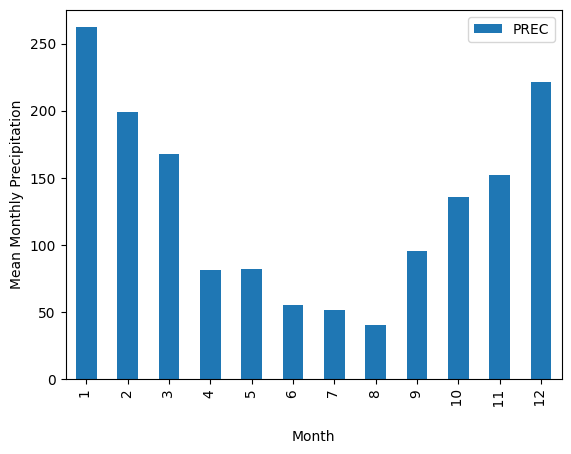

In [ ]:
# Convert 'PREC' column to numeric, handling errors
precipitacao_dados['PREC'] = pd.to_numeric(precipitacao_dados['PREC'], errors='coerce')

# Group data by year and month, then calculate the mean monthly precipitation
monthly_precipitation = precipitacao_dados.groupby(['Year', 'Month'])['PREC'].sum().reset_index()

monthly_precipitation = monthly_precipitation.groupby(['Month'])['PREC'].mean().reset_index()

# Rename the columns

# Display the result
monthly_precipitation.plot(x='Month', y='PREC', kind='bar')
plt.xlabel('Month')
plt.ylabel('Mean Monthly Precipitation')

### Determinar o início do ano hidrológico

<Figure size 1000x600 with 0 Axes>

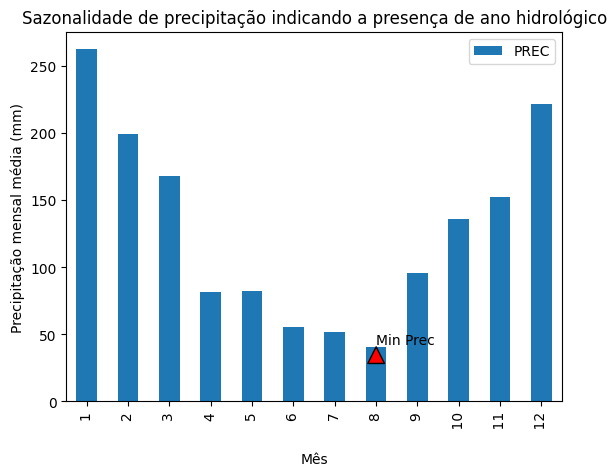

In [ ]:
# Find the month with the lowest precipitation
min_precipitation_month = int(monthly_precipitation['Month'][monthly_precipitation['PREC'].idxmin()]) - 1

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
monthly_precipitation.plot(x='Month', y='PREC', kind='bar')
plt.xlabel('Mês')
plt.ylabel('Precipitação mensal média (mm)')

# Add the red arrow
plt.annotate('Min Prec', xy=(min_precipitation_month, monthly_precipitation['PREC'].min()),
             xytext=(min_precipitation_month, monthly_precipitation['PREC'].min() + 2), # Adjust vertical offset
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.title('Sazonalidade de precipitação indicando a presença de ano hidrológico')

plt.show()

### Ajustar o ano hidrológico

In [ ]:
ano_hidrologico_inicio = 10

# Define a function to adjust the dates according to the hydrological year
def adjust_hydrological_year(df):
    # Create a copy to avoid modifying the original DataFrame
    if(ano_hidrologico_inicio == 1):
      df_adjusted = df.copy()
      df_adjusted['hydro_year'] = df_adjusted['Year']
      df_adjusted['month'] = df_adjusted['Month']
    else:
      df_adjusted = df.copy()

    # Convert the 'data' column to datetime objects if it's not already
      if not pd.api.types.is_datetime64_any_dtype(df_adjusted['data']):
          df_adjusted['data'] = pd.to_datetime(df_adjusted['data'])

      # Extract year and month
      df_adjusted['hydro_year'] = df_adjusted['data'].dt.year
      df_adjusted['month'] = df_adjusted['data'].dt.month

      # Adjust the hydrological year
      df_adjusted.loc[df_adjusted['month'] >= ano_hidrologico_inicio, 'hydro_year'] +=1

      # Create the hydrological date
      df_adjusted['hydro_date'] = pd.to_datetime(df_adjusted['hydro_year'].astype(str) + '-' + df_adjusted['month'].astype(str) + '-' + df_adjusted['data'].dt.day.astype(str), format='%Y-%m-%d')

    return df_adjusted

# Assuming 'precipitacao_dados' is your DataFrame
precipitacao_dados = adjust_hydrological_year(precipitacao_dados)

# Now you can use the 'hydro_date' column for further analysis
# Example: Group data by hydrological year
hydro_year_precipitation = precipitacao_dados.groupby('hydro_year')['PREC'].mean().reset_index()

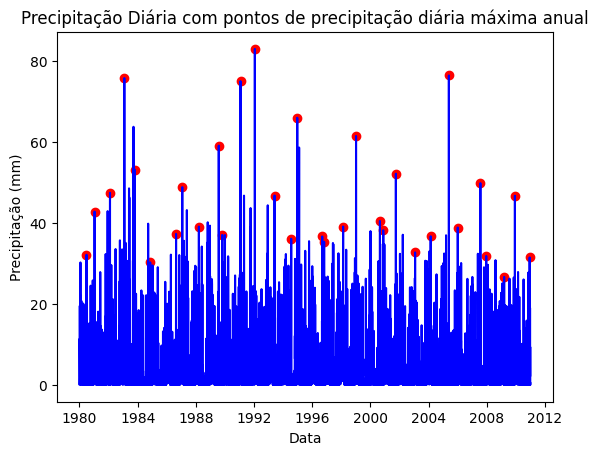

In [ ]:
# Calcular a precipitação máxima diária anual
precipitacao_max_anual = precipitacao_dados.loc[precipitacao_dados.groupby('hydro_year')['PREC'].idxmax()].reset_index()
precipitacao_max_anual = precipitacao_max_anual[['data', 'hydro_year','PREC']]
precipitacao_max_anual = precipitacao_max_anual.rename(columns={'PREC': 'Max_PREC'})
precipitacao_max_anual


#Meses do ano
#meses = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']

#Plotagem
plt.plot(data, precipitacao_dados['PREC'], color="blue")
plt.scatter(precipitacao_max_anual['data'], precipitacao_max_anual['Max_PREC'], color="red")
plt.title('Precipitação Diária com pontos de precipitação diária máxima anual')
plt.xlabel('Data')
plt.ylabel('Precipitação (mm)')
plt.show()

## Ajustar equações de distribuição de probabilidades empíricas aplicadas aos dados observados

### Kimbal

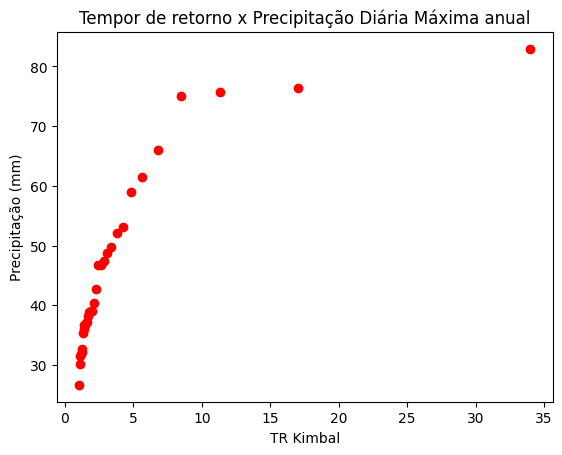

In [ ]:
precipitacao_max_anual_sort = precipitacao_max_anual.sort_values(by = "Max_PREC",ascending=False).reset_index()
precipitacao_max_anual_sort['Prob_kimbal'] = np.arange(1,len(precipitacao_max_anual_sort)+1)/(len(precipitacao_max_anual_sort)+2)
precipitacao_max_anual_sort['TR_kimbal'] = 1/precipitacao_max_anual_sort['Prob_kimbal']


plt.scatter(precipitacao_max_anual_sort['TR_kimbal'], precipitacao_max_anual_sort['Max_PREC'], color="red")
plt.title('Tempor de retorno x Precipitação Diária Máxima anual')
plt.xlabel('TR Kimbal')
plt.ylabel('Precipitação (mm)')
plt.show()

### Califórnia

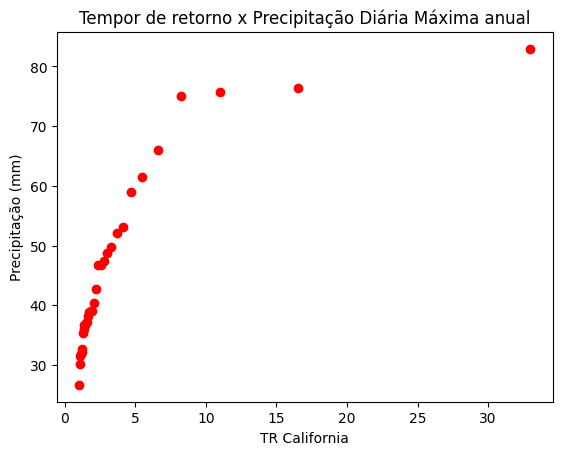

In [ ]:
precipitacao_max_anual_sort['Prob_california'] = np.arange(1,len(precipitacao_max_anual_sort)+1)/(len(precipitacao_max_anual_sort)+1)
precipitacao_max_anual_sort['TR_california'] = 1/precipitacao_max_anual_sort['Prob_california']


plt.scatter(precipitacao_max_anual_sort['TR_california'], precipitacao_max_anual_sort['Max_PREC'], color="red")
plt.title('Tempor de retorno x Precipitação Diária Máxima anual')
plt.xlabel('TR California')
plt.ylabel('Precipitação (mm)')
plt.show()

### Log-normal

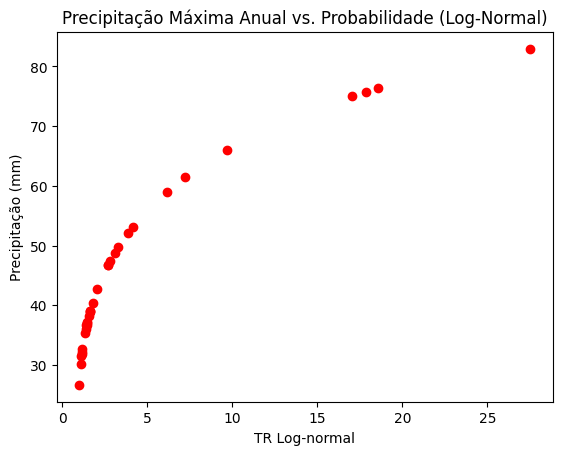

In [ ]:
# Fit a log-normal distribution to the data
from scipy.stats import lognorm

shape, loc, scale = lognorm.fit(precipitacao_max_anual_sort['Max_PREC'])

# Calculate probabilities for the fitted log-normal distribution
precipitacao_max_anual_sort['Prob_lognormal'] = 1-lognorm.cdf(precipitacao_max_anual_sort['Max_PREC'], shape, loc=loc, scale=scale)
precipitacao_max_anual_sort['TR_lognormal'] = 1/(precipitacao_max_anual_sort['Prob_lognormal'])

# Now you have the 'Prob_lognormal' column in your DataFrame.
# You can adjust 'Max_PREC' values or parameters of the lognorm.fit function if necessary to achieve the desired probabilities.

# Example: plotting the results
plt.scatter(precipitacao_max_anual_sort['TR_lognormal'], precipitacao_max_anual_sort['Max_PREC'], color="red")
plt.title('Precipitação Máxima Anual vs. Probabilidade (Log-Normal)')
plt.xlabel('TR Log-normal')
plt.ylabel('Precipitação (mm)')
plt.show()


### Gumbel

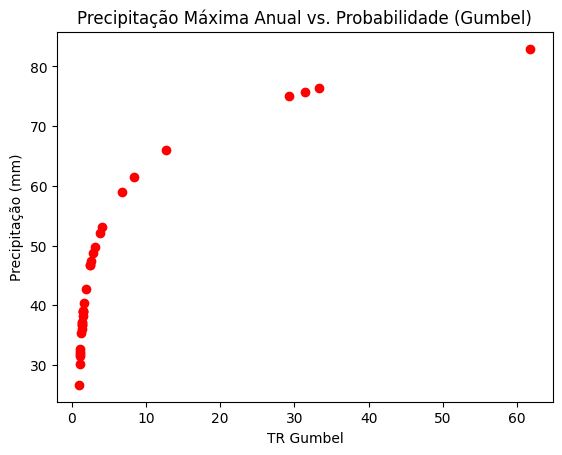

In [ ]:
# prompt: ajustar Max_PREC para log-normal para obter as probabilidades Gumbel

# Calculate Gumbel parameters
import scipy.stats as stats

# Fit the Gumbel distribution
loc, scale = stats.gumbel_r.fit(precipitacao_max_anual_sort['Max_PREC'])

# Calculate probabilities for the fitted Gumbel distribution
precipitacao_max_anual_sort['Prob_gumbel'] = 1 - stats.gumbel_r.cdf(precipitacao_max_anual_sort['Max_PREC'], loc=loc, scale=scale)
precipitacao_max_anual_sort['TR_gumbel'] = 1 / (precipitacao_max_anual_sort['Prob_gumbel'])

# Now you have the 'Prob_gumbel' column and 'TR_gumbel' in your DataFrame.

# Example: plotting the results
plt.scatter(precipitacao_max_anual_sort['TR_gumbel'], precipitacao_max_anual_sort['Max_PREC'], color="red")
plt.title('Precipitação Máxima Anual vs. Probabilidade (Gumbel)')
plt.xlabel('TR Gumbel')
plt.ylabel('Precipitação (mm)')
plt.show()


### Pearson 3

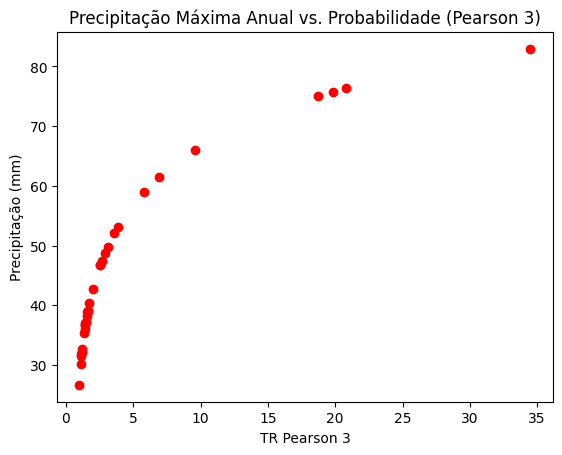

In [ ]:

# Fit the Pearson 3 distribution

skew, loc, scale = stats.pearson3.fit(precipitacao_max_anual_sort['Max_PREC'], loc=0, scale=1)

# Calculate probabilities and return periods for Pearson 3
precipitacao_max_anual_sort['Prob_pearson3'] = 1 -stats.pearson3.cdf(precipitacao_max_anual_sort['Max_PREC'], skew = skew, loc=loc, scale=scale)
precipitacao_max_anual_sort['TR_pearson3'] = 1 / ( precipitacao_max_anual_sort['Prob_pearson3'])

# Now you have 'Prob_pearson3' and 'TR_pearson3' columns in your DataFrame.

# Example: Plotting the Pearson 3 results
plt.scatter(precipitacao_max_anual_sort['TR_pearson3'], precipitacao_max_anual_sort['Max_PREC'], color="red")
plt.title('Precipitação Máxima Anual vs. Probabilidade (Pearson 3)')
plt.xlabel('TR Pearson 3')
plt.ylabel('Precipitação (mm)')
plt.show()

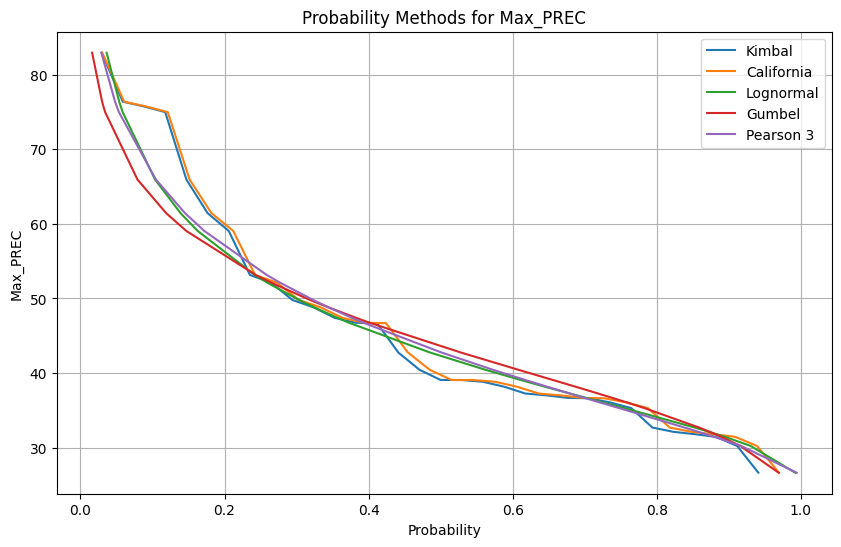

In [ ]:
# prompt: precipitacao_max_anual_sort.plot(x='Prob_kimbal', y='Max_PREC')
# precipitacao_max_anual_sort.plot(x='Prob_california', y='Max_PREC')
# precipitacao_max_anual_sort.plot(x='Prob_lognormal', y='Max_PREC')
# precipitacao_max_anual_sort.plot(x='Prob_gumbel', y='Max_PREC') adicionar todos os plots em um só com uma legenda indicando o nome do método de estimar a probabilidade

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

plt.plot(precipitacao_max_anual_sort['Prob_kimbal'], precipitacao_max_anual_sort['Max_PREC'], label='Kimbal')
plt.plot(precipitacao_max_anual_sort['Prob_california'], precipitacao_max_anual_sort['Max_PREC'], label='California')
plt.plot(precipitacao_max_anual_sort['Prob_lognormal'], precipitacao_max_anual_sort['Max_PREC'], label='Lognormal')
plt.plot(precipitacao_max_anual_sort['Prob_gumbel'], precipitacao_max_anual_sort['Max_PREC'], label='Gumbel')
plt.plot(precipitacao_max_anual_sort['Prob_pearson3'], precipitacao_max_anual_sort['Max_PREC'], label='Pearson 3')

plt.xlabel('Probability')
plt.ylabel('Max_PREC')
plt.title('Probability Methods for Max_PREC')
plt.legend()
plt.grid(True)
plt.show()

## Aplicar testes de aderência estatísticos (e.g., Kolgomorov-Smirnov)

In [ ]:
from scipy.stats import kstest

# Testes de Kolmogorov-Smirnov
ks_kimbal = kstest(precipitacao_max_anual_sort['Max_PREC'], 'expon', args=(1/np.mean(precipitacao_max_anual_sort['Max_PREC']),0))
ks_california = kstest(precipitacao_max_anual_sort['Max_PREC'], 'expon', args=(1/np.mean(precipitacao_max_anual_sort['Max_PREC']),0))
ks_lognormal = kstest(precipitacao_max_anual_sort['Max_PREC'], 'lognorm', args=(shape, loc, scale))
ks_gumbel = kstest(precipitacao_max_anual_sort['Max_PREC'], 'gumbel_r', args=(loc, scale))
ks_pearson3 = kstest(precipitacao_max_anual_sort['Max_PREC'], 'pearson3', args=(skew, loc, scale))


print("Teste de Kolmogorov-Smirnov:")
print("Kimbal:", ks_kimbal)
print("California:", ks_california)
print("Log-normal:", ks_lognormal)
print("Gumbel:", ks_gumbel)
print("Pearson 3:", ks_pearson3)


Teste de Kolmogorov-Smirnov:
Kimbal: KstestResult(statistic=np.float64(nan), pvalue=np.float64(nan), statistic_location=np.float64(26.655), statistic_sign=np.int8(-1))
California: KstestResult(statistic=np.float64(nan), pvalue=np.float64(nan), statistic_location=np.float64(26.655), statistic_sign=np.int8(-1))
Log-normal: KstestResult(statistic=np.float64(0.7107995178023048), pvalue=np.float64(7.876956435860964e-17), statistic_location=np.float64(49.801), statistic_sign=np.int8(1))
Gumbel: KstestResult(statistic=np.float64(0.30300422244010805), pvalue=np.float64(0.0041983611572123936), statistic_location=np.float64(40.451), statistic_sign=np.int8(1))
Pearson 3: KstestResult(statistic=np.float64(0.11742155186566211), pvalue=np.float64(0.7259957376546871), statistic_location=np.float64(39.082), statistic_sign=np.int8(1))


/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2110: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [ ]:
t30_5 = 0.34
t30_10 = 0.54
t30_15 = 0.70
t30_20 = 0.81
t30_25 = 0.91
t1_30 = 0.74
t24_1 = 0.42
t24_6 = 0.72
t24_8 = 0.78
t24_10 = 0.82
t24_12 = 0.85
t24 = 1.14

time = [5,10,15,20,25,30,60,360,480,600,720,1440]



In [ ]:
# prompt: Aplicar os coeficientes de desagregação da célula anterior para gerar as chuvas desagregadas nos seguintes tempos 5,10,15,20,25,30,60,360,480,600,720,1440 min

# Coeficientes de desagregação (exemplo - substitua pelos seus valores)
coeficientes = {
    5: t30_5,
    10: t30_10,
    15: t30_15,
    20: t30_20,
    25: t30_25,
    30: t1_30,
    60: t24_6,
    360: t24_1,
    480: t24_8,
    600: t24_10,
    720: t24_12,
    1440: t24
}

# Criar dicionário para armazenar as chuvas desagregadas
chuvas_desagregadas = {}

# Aplicar os coeficientes aos valores de precipitação máxima anual
for t in time:
  chuvas_desagregadas[t] = precipitacao_max_anual_sort['Max_PREC'] * coeficientes[t]

# Criar um DataFrame com os resultados
df_chuvas_desagregadas = pd.DataFrame(chuvas_desagregadas)
df_chuvas_desagregadas = pd.concat([precipitacao_max_anual_sort, df_chuvas_desagregadas], axis=1)
df_chuvas_desagregadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            32 non-null     int64         
 1   data             32 non-null     datetime64[ns]
 2   hydro_year       32 non-null     int32         
 3   Max_PREC         32 non-null     float64       
 4   Prob_kimbal      32 non-null     float64       
 5   TR_kimbal        32 non-null     float64       
 6   Prob_california  32 non-null     float64       
 7   TR_california    32 non-null     float64       
 8   Prob_lognormal   32 non-null     float64       
 9   TR_lognormal     32 non-null     float64       
 10  Prob_gumbel      32 non-null     float64       
 11  TR_gumbel        32 non-null     float64       
 12  Prob_pearson3    32 non-null     float64       
 13  TR_pearson3      32 non-null     float64       
 14  5                32 non-null     float64    

In [ ]:
# Pivotar os dados para que fique uma coluna com os tempos em minutos e os valores desagregados em outra coluna
df_chuvas_desagregadas_long = df_chuvas_desagregadas.melt(
    id_vars=['data', 'hydro_year', 'Max_PREC', 'Prob_pearson3', 'TR_pearson3'],
    var_name='Tempo',
    value_name='PREC_DES'
)

# Converter Tempo para numérico
df_chuvas_desagregadas_long['Tempo'] = pd.to_numeric(df_chuvas_desagregadas_long['Tempo'], errors='coerce')

# Calcular a intensidade da chuva (transformando mm acumulados para taxa mm/h)
df_chuvas_desagregadas_long['PREC_DES'] = df_chuvas_desagregadas_long['PREC_DES'] / df_chuvas_desagregadas_long['Tempo'] * 60

# Exibir o DataFrame final
df_chuvas_desagregadas_long

,data,hydro_year,Max_PREC,Prob_pearson3,TR_pearson3,Tempo,PREC_DES
0,1992-01-22,1992,82.920,0.028991,34.493541,NaN,NaN
1,2005-05-25,2005,76.361,0.047995,20.835637,NaN,NaN
2,1983-02-01,1983,75.726,0.050370,19.852949,NaN,NaN
3,1991-01-27,1991,74.963,0.053374,18.735624,NaN,NaN
4,1994-12-22,1995,65.935,0.104690,9.551984,NaN,NaN
...,...,...,...,...,...,...,...
667,1980-06-26,1980,32.128,0.858105,1.165359,1440.0,1.526080
668,2007-12-19,2008,31.821,0.868228,1.151771,1440.0,1.511497
669,2010-12-13,2011,31.459,0.879962,1.136413,1440.0,1.494302
670,1984-11-12,1985,30.237,0.917506,1.089911,1440.0,1.436257


In [ ]:
df_chuvas_desagregadas_long = df_chuvas_desagregadas_long.rename(columns={'TR_pearson3': 'TR'})

In [ ]:
def idf_sherman(K,TR,a,b,tempo,c):
  i = (K*TR**a)/((b+tempo)**c)
  return(i)

# Define the IDF function
def idf_sherman(K, TR, a, b, tempo, c):
    # Using np.power to handle potential overflows
    return (K * np.power(TR, a)) / (np.power(b + tempo, c))


In [ ]:
import numpy as np
from scipy.optimize import least_squares


# Residuals function
def residuals(params, TR, tempo, i_observed):
    K, a, b, c = params
    # Convert Pandas Series to NumPy arrays
    i_calculated = idf_sherman(K, TR, a, b, tempo, c)

    return ((np.mean(np.abs(i_observed - i_calculated))))


# Prepare initial guess and bounds
params0 = [1000, 1, 10, 1]
bounds = ([0.01, 0.01, 0.01, 0.01], [10000, 5, 50, 5])

result = least_squares(residuals,
                       params0,
                       bounds= bounds,
                       args=(df_chuvas_desagregadas_long['TR'],
                             df_chuvas_desagregadas_long['Tempo'],
                             df_chuvas_desagregadas_long['PREC_DES']))
K, a, b, c = result['x']

print(result['x'])

[1.00313872e+03 2.91270895e-01 9.84316605e+00 7.56744328e-01]


In [ ]:
residuals([K, a, b, c], df_chuvas_desagregadas_long['TR'].to_numpy(),
                             df_chuvas_desagregadas_long['Tempo'].to_numpy(),
                             df_chuvas_desagregadas_long['PREC_DES'].to_numpy())

np.float64(nan)

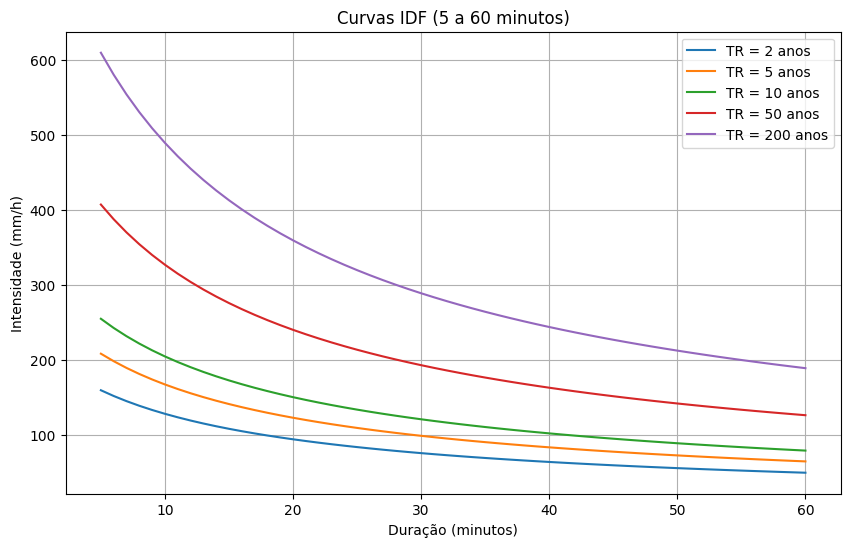

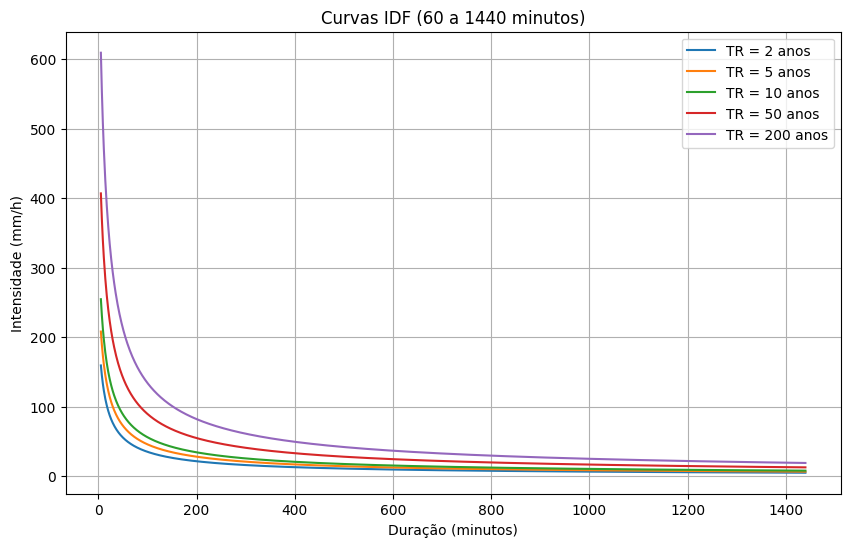

In [ ]:
# Criar um DataFrame para armazenar os resultados das curvas IDF
idf_results = pd.DataFrame()

# Tempos de retorno (TR)
trs = [2, 5, 10, 50, 200]

# Loop pelos tempos de retorno
for tr in trs:
    # Calcular as intensidades para diferentes durações de chuva
    duracoes = np.arange(5, 1441)  # Durações de 1 a 1440 minutos
    intensidades = idf_sherman(K, tr, a, b, duracoes, c)

    # Criar um DataFrame temporário com os resultados para o TR atual
    temp_df = pd.DataFrame({'Duracao': duracoes, 'Intensidade': intensidades, 'TR': tr})

    # Concatenar os resultados ao DataFrame principal
    idf_results = pd.concat([idf_results, temp_df])

# Criar o primeiro gráfico (5 a 60 minutos)
plt.figure(figsize=(10, 6))
for tr in trs:
    subset = idf_results[(idf_results['TR'] == tr) & (idf_results['Duracao'] <= 60)]
    plt.plot(subset['Duracao'], subset['Intensidade'], label=f'TR = {tr} anos')
plt.xlabel('Duração (minutos)')
plt.ylabel('Intensidade (mm/h)')
plt.title('Curvas IDF (5 a 60 minutos)')
plt.legend()
plt.grid(True)
plt.show()

# Criar o segundo gráfico (60 a 1440 minutos)
plt.figure(figsize=(10, 6))
for tr in trs:
    subset = idf_results[(idf_results['TR'] == tr) & (idf_results['Duracao'] >= 5)]
    plt.plot(subset['Duracao'], subset['Intensidade'], label=f'TR = {tr} anos')
plt.xlabel('Duração (minutos)')
plt.ylabel('Intensidade (mm/h)')
plt.title('Curvas IDF (60 a 1440 minutos)')
plt.legend()
plt.grid(True)
plt.show()